In [69]:
# import os
import os.path
os.environ['USE_PYGEOS'] = '0'
import xarray as xr
import numpy as np
import pandas as pd
import fiona
import glob
import dask_geopandas
import geopandas as gpd
import time
from copy import deepcopy
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import aggfly
import netCDF4

import dask
from dask.distributed import Client
from dask.diagnostics import ProgressBar

from aggfly import regions
from aggfly import dataset, regions, grid_weights
from aggfly.aggregate import TemporalAggregator, SpatialAggregator
# from aggfly.aggregate import TemporalAggregator, SpatialAggregator

ProgressBar().register()
# client = Client(n_workers=2)

project_dir = '/user/gb2884/aggfly/notebooks/giovanni_example'

In [70]:
gdf = gpd.read_file("/user/gb2884/Macro_Enviro_Dev/1_Data/world_example/IPUMSI_world_release2020/world_countries_2020.shp")
print(gdf.head())
#gdf.plot(color='blue', legend=True)



   OBJECTID                    CNTRY_NAME CNTRY_CODE  BPL_CODE  \
0         1                       Algeria        012   13010.0   
1         2                        Angola        024   12010.0   
2         3  In dispute South Sudan/Sudan       9999   99999.0   
3         4                         Benin        204   15010.0   
4         5                      Botswana        072   14010.0   

                                            geometry  
0  MULTIPOLYGON (((-2.05592 35.07370, -2.05675 35...  
1  MULTIPOLYGON (((12.79760 -4.41685, 12.79875 -4...  
2  POLYGON ((28.08408 9.34722, 28.03889 9.34722, ...  
3  MULTIPOLYGON (((1.93753 6.30122, 1.93422 6.299...  
4  POLYGON ((25.16312 -17.77816, 25.16383 -17.778...  


In [71]:
import os
import os.path

# Years to aggregate
years = np.arange(1951,2020)
years = years[years != 1959]

georegions = regions.from_path("/user/gb2884/aggfly/notebooks/giovanni_example/Data/usa_simple_noHI.shp",regionid='geometry')
#georegions = regions.from_path('/user/gb2884/Macro_Enviro_Dev/1_Data/world_example/IPUMSI_world_release2020/world_countries_2020.shp',regionid='OBJECTID')
georegions.shp["GEOID"]=range(50)


#RI = georegions.shp[georegions.shp['GEOID'] == 39]
RI = georegions.shp[(georegions.shp['GEOID'] == 2) | (georegions.shp['GEOID'] == 39)]

#RI = georegions.shp.loc[georegions.shp.GEOID=='1']
#RI = georegions.shp.loc[georegions.shp.STATEFP=='44']
#RI = georegions.shp.loc[georegions.shp.CNTRY_CODE == '012']

#georegions = georegions.sel(RI.GEOID)
#georegions.shp = georegions.shp[georegions.shp['GEOID'].isin(RI['GEOID'])]

print(georegions.shp.columns)

Index(['geometry', 'GEOID'], dtype='object')


In [72]:
print(RI)
print(georegions.shp.shape)
georegions
print(georegions.shp)

                                             geometry  GEOID
2   POLYGON ((-110.97208 31.33012, -111.04955 31.3...      2
39  MULTIPOLYGON (((-80.41515 32.49290, -80.44278 ...     39
(50, 2)
                                             geometry  GEOID
0   MULTIPOLYGON (((-88.02556 30.51194, -88.02611 ...      0
1   MULTIPOLYGON (((-179.11111 51.30194, -179.0713...      1
2   POLYGON ((-110.97208 31.33012, -111.04955 31.3...      2
3   MULTIPOLYGON (((-94.04562 33.02060, -94.04996 ...      3
4   MULTIPOLYGON (((-119.46037 33.25665, -119.4538...      4
5   POLYGON ((-102.04227 36.99223, -105.71882 36.9...      5
6   MULTIPOLYGON (((-72.56750 41.26667, -72.65746 ...      6
7   MULTIPOLYGON (((-75.17306 38.57583, -75.08361 ...      7
8   POLYGON ((-77.04446 38.99281, -76.91743 38.886...      8
9   MULTIPOLYGON (((-82.10053 24.56680, -82.12180 ...      9
10  MULTIPOLYGON (((-82.18080 30.37038, -82.22929 ...     10
11  POLYGON ((-111.04626 42.01016, -113.42534 41.9...     11
12  POLYGON ((-8

<Axes: >

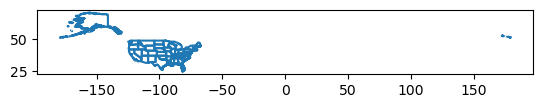

In [73]:
georegions.shp.boundary.plot()

In [74]:
def preprocess_era5l(array):
    # Function for cleaning the era5l data.
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):   
        # Reformat longitude
        array.coords['longitude'] = (array.coords['longitude'] + 180) % 360 - 180
        array = array.sortby(array.longitude)
        # Kelvin -> Celsius
        array = array - 273.15
    return array

# Open example dataset to construct weights.
clim = dataset.from_path(
    #f"/Users\gb2884/The Lab Dropbox/Giovanni Brocca/Macro_Enviro_Dev/1_Data/world_example/era_june_2000_2tm.nc", 
    #f"/Users/gb2884/The Lab Dropbox/Giovanni Brocca/Macro_Enviro_Dev/1_Data/IPUMS_1level_example/era_1st_June_2000_tm.nc",
    f"/user/gb2884/Macro_Enviro_Dev/1_Data/IPUMS_1level_example/era_2000_2tm.nc",
    var = 't2m',
    engine = 'netcdf4',
    name='era5',
    clip_geom=georegions,
    preprocess = preprocess_era5l)

clim.rechunk(chunks=-1)

# Calculate area and pop layer weights.
weights = grid_weights.from_objects(
    clim,
    georegions,
    wtype=None,
    simplify=0.001,
    project_dir=project_dir)


#clim.clip_data_to_georegions_extent(georegions)

print("Loading weights")
#w = weights.weights()
#nzw_ind = np.isin(clim.grid.index, w.cell_id).nonzero()
#print(w) 
#print(nzw_ind)
#print(clim.grid.index)
#print(w.cell_id)
weights.calculate_weights()

/user/gb2884/aggfly/notebooks/giovanni_example/tmp/GridWeights/mod-9c23708f3e79a8e
Loading weights
[########################################] | 100% Completed | 102.13 ms
[########################################] | 100% Completed | 102.22 ms
[########################################] | 100% Completed | 101.94 ms
Loading rescaled weights from cache
Cache dictionary:
{'func': 'weights', 'raster_weights': None}


In [75]:
print("Scheduling aggregation")
dailies = [
    TemporalAggregator('avg', 'time.date')
]
monthly = TemporalAggregator('avg', 'time.month')

Scheduling aggregation


In [76]:
out = pd.DataFrame()
#for year in years:
#    print(year)
#    start = time.time()
year = 2000

print('Loading climate data')
clim = dataset.from_path(
    #f"/Users\gb2884/The Lab Dropbox/Giovanni Brocca/Macro_Enviro_Dev/1_Data/world_example/era_june_2000_2tm.nc", 
    #f"/Users/gb2884/The Lab Dropbox/Giovanni Brocca/Macro_Enviro_Dev/1_Data/IPUMS_1level_example/era_1st_June_2000_tm.nc",
    f"/user/gb2884/Macro_Enviro_Dev/1_Data/IPUMS_1level_example/era_2000_2tm.nc",
    var = 't2m',
    engine = 'netcdf4',
    name='era5',
    clip_geom=georegions,
    preprocess = preprocess_era5l)
#clim.update(clim.da.persist())

clim.rechunk(chunks=-1)



print('Aggregating')
day_ds = [x.map_execute(clim, weights) for x in dailies]
month_ds = [monthly.map_execute(x, weights) for x in day_ds]

Loading climate data
Aggregating


In [77]:
clim.da
#clim.da.sel(time=clim.da.time[0]).plot()

<xarray.DataArray 't2m' (latitude: 188, longitude: 1437, time: 8616)>
dask.array<rechunk-merge, shape=(188, 1437, 8616), dtype=float32, chunksize=(188, 1437, 8616), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -179.2 -179.0 -178.8 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 71.25 71.0 70.75 70.5 ... 25.0 24.75 24.5
  * time       (time) datetime64[ns] 2000-01-01 ... 2000-12-30T23:00:00

In [114]:
names = ['avg']
df = SpatialAggregator(month_ds, weights, names=names).compute()
    
# Clean output dataset and append
df = df.reset_index().rename(columns={'time':'month'})
df['year'] = year
df = df[['region_id', 'year', 'month'] + names]
df = georegions.shp[['GEOID']].merge(df, left_index=True, right_on='region_id')

out = pd.concat([out, df])

COMPUTING
[########################################] | 100% Completed | 26.58 s
[########################################] | 100% Completed | 26.67 s
[########################################] | 100% Completed | 26.75 s
[########################################] | 100% Completed | 285.37 ms
[########################################] | 100% Completed | 290.92 ms
[########################################] | 100% Completed | 383.37 ms


In [99]:
#out.reset_index().to_feather("/home3/dth2133/data/clim_data_requests/maya/temp_data_maya.feather")

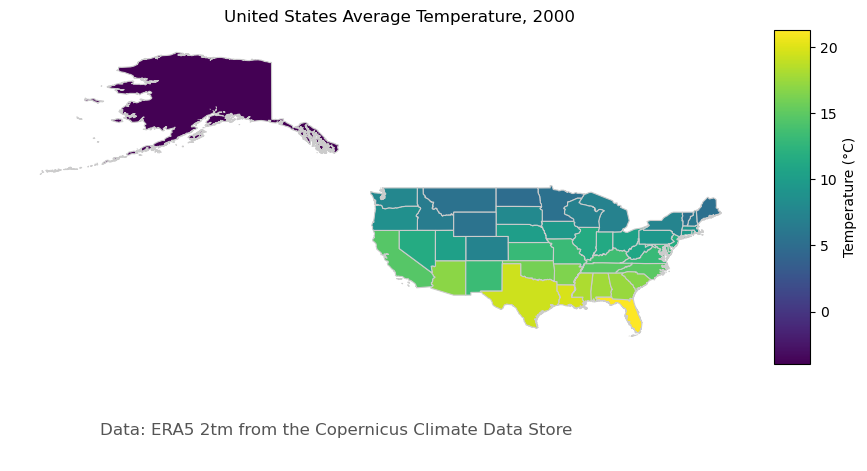

In [190]:
# Computing
slc = out.loc[out.year==2000].groupby('GEOID').mean()
merged = georegions.shp.merge(slc, right_index=True, left_on='GEOID')

# Plotting the map
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))

merged.plot(column='avg', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8')

#merged_plot.set_xlim(-180, -60)
#plt.imshow(merged_plot, cmap='gray', aspect=2)

plt.title('United States Average Temperature, 2000')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Set the axis limits to the desired latitude range
min_lat=-180
max_lat=-60
plt.xlim(min_lat, max_lat)
plt.ylim(20, 75) 

# remove the axis
ax.axis('off')
# add a title
#ax.set_title('Population of Rajasthan', fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('Data: ERA5 2tm from the Copernicus Climate Data Store',xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Create colorbar as a legend
#sm = plt.cm.ScalarMappable(cmap='viridis')
#sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=merged['avg'].min(), vmax=merged['avg'].max())), cax=cax)
cbar.set_label('Temperature (°C)')

# Save and show the plot
plt.savefig(project_dir+"/Output/merged.png", dpi=900)
plt.show()




In [81]:
print(df)
print(df_GEOID0_1)
#print(georegions.shp.columns)
#print(slc["avg"])

     GEOID  region_id  year  month        avg
552      0          0  2000      1   8.476435
553      0          0  2000      2  11.353690
554      0          0  2000      3  14.900635
555      0          0  2000      4  16.036264
556      0          0  2000      5  23.502539
..     ...        ...   ...    ...        ...
151     49         49  2000      8  21.101135
152     49         49  2000      9  12.184028
153     49         49  2000     10   5.758836
154     49         49  2000     11  -8.140402
155     49         49  2000     12  -8.997078

[600 rows x 5 columns]
     GEOID  region_id  year  month        avg       date
552      0          0  2000      1   8.476435 2000-01-01
553      0          0  2000      2  11.353690 2000-02-01
554      0          0  2000      3  14.900635 2000-03-01
555      0          0  2000      4  16.036264 2000-04-01
556      0          0  2000      5  23.502539 2000-05-01
557      0          0  2000      6  25.329291 2000-06-01
558      0          0  20

                                            geometry  GEOID  region_id  \
1  MULTIPOLYGON (((-179.11111 51.30194, -179.0713...      1        1.0   
4  MULTIPOLYGON (((-119.46037 33.25665, -119.4538...      4        4.0   

     year  month        avg  
1  2000.0    6.5  -3.990789  
4  2000.0    6.5  14.581862  


<Axes: >

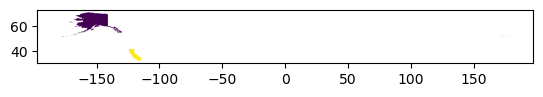

In [154]:
# Monthly map time series for 2 states
month_merged=georegions.shp.merge(slc, right_index=True, left_on='GEOID')
month_merged=month_merged[(month_merged['GEOID'] == 4) | (month_merged['GEOID'] == 1)]
print(month_merged)
month_merged.plot(column='avg')


     GEOID       State
0        1      Alaska
1        1      Alaska
2        1      Alaska
3        1      Alaska
4        1      Alaska
5        1      Alaska
6        1      Alaska
7        1      Alaska
8        1      Alaska
9        1      Alaska
10       1      Alaska
11       1      Alaska
252      4  California
253      4  California
254      4  California
255      4  California
256      4  California
257      4  California
258      4  California
259      4  California
260      4  California
261      4  California
262      4  California
263      4  California


/tmp/7236656.1.large.q/ipykernel_2692/1124318298.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_GEOID0_1['State'] = df_GEOID0_1['GEOID'].map(state_mapping)


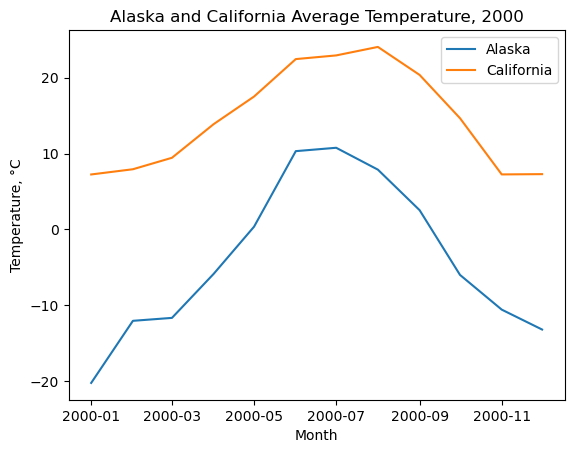

In [191]:
### Monthly time series for 2 states

#df['date'] = df['month'].to_datetime(df['month'], format='%m', errors='coerce')
#df['date']=pd.to_datetime(df['month'], format='%m', errors='coerce')
#df['date']=pd.to_datetime(df['month']).dt.strftime('%Y-%m')
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2))
#df['date']=df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2)

# Selecting California and Alaska
df_GEOID0_1 = df[(df['GEOID'] == 4) | (df['GEOID'] == 1)]
# Create a dictionary to map 'GEOID' values to state names
state_mapping = {1: 'Alaska', 4: 'California'}
# Create the 'State' column by mapping 'GEOID' to state names
df_GEOID0_1['State'] = df_GEOID0_1['GEOID'].map(state_mapping)
print(df_GEOID0_1[['GEOID', 'State']])

# Plotting the time series for monthly average temperatures
for state, group in df_GEOID0_1.groupby('State'):
    plt.plot(group['date'], group['avg'], label=f'{state}')

#plt.plot(df_GEOID0_1.index, df_GEOID0_1['avg'])

plt.xlabel('Month')
plt.ylabel('Temperature, °C')
plt.title('Alaska and California Average Temperature, 2000')
plt.legend()
plt.savefig(project_dir+"/Output/monthly_2states.png")
plt.show()

In [173]:
# Spatially aggregating for daily
names = ['avg']
df_day = SpatialAggregator(day_ds, weights, names=names).compute()
    
# Clean output dataset and append
df_day = df_day.reset_index().rename(columns={'time':'day'})
df_day['year'] = year
df_day = df_day[['region_id', 'year', 'day'] + names]
df_day = georegions.shp[['GEOID']].merge(df_day, left_index=True, right_on='region_id')

out = pd.concat([out, df_day])

COMPUTING
[########################################] | 100% Completed | 27.27 s
[########################################] | 100% Completed | 27.30 s
[########################################] | 100% Completed | 27.31 s
[########################################] | 100% Completed | 345.82 ms
[########################################] | 100% Completed | 392.25 ms
[########################################] | 100% Completed | 441.37 ms


In [175]:
print(df_day)

       GEOID  region_id  year        day        avg
16514      0          0  2000 2000-01-01  14.656754
16515      0          0  2000 2000-01-02  16.184689
16516      0          0  2000 2000-01-03  18.886112
16517      0          0  2000 2000-01-04  15.421479
16518      0          0  2000 2000-01-05   4.397750
...      ...        ...   ...        ...        ...
4662      49         49  2000 2000-12-26 -10.805074
4663      49         49  2000 2000-12-27  -7.340805
4664      49         49  2000 2000-12-28  -5.409203
4665      49         49  2000 2000-12-29 -10.897355
4666      49         49  2000 2000-12-30  -9.651814

[17950 rows x 5 columns]


/tmp/7236656.1.large.q/ipykernel_2692/1121813486.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_day_GEOID0_1['State'] = df_day_GEOID0_1['GEOID'].map(state_mapping)


      GEOID       State
0         1      Alaska
1         1      Alaska
2         1      Alaska
3         1      Alaska
4         1      Alaska
...     ...         ...
7893      4  California
7894      4  California
7895      4  California
7896      4  California
7897      4  California

[718 rows x 2 columns]


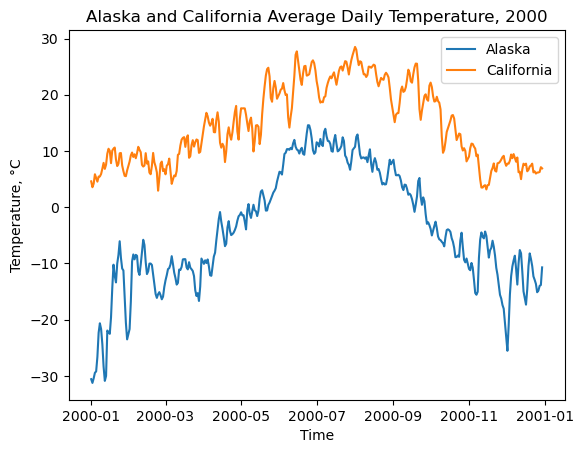

In [192]:
### Daily time series for 2 states

#df_day['date'] = df_day['month'].to_datetime(df_day['month'], format='%m', errors='coerce')
#df_day['date']=pd.to_datetime(df_day['month'], format='%m', errors='coerce')
#df_day['date']=pd.to_datetime(df_day['month']).dt.strftime('%Y-%m')
df_day['date'] = pd.to_datetime(df_day['day'].astype(str))
#df_day['date']=df_day['year'].astype(str) + '-' + df_day['month'].astype(str).str.zfill(2)

# Selecting California and Alaska
df_day_GEOID0_1 = df_day[(df_day['GEOID'] == 4) | (df_day['GEOID'] == 1)]
# Create a dictionary to map 'GEOID' values to state names
state_mapping = {1: 'Alaska', 4: 'California'}
# Create the 'State' column by mapping 'GEOID' to state names
df_day_GEOID0_1['State'] = df_day_GEOID0_1['GEOID'].map(state_mapping)
print(df_day_GEOID0_1[['GEOID', 'State']])

# Plotting the time series for monthly average temperatures
for state, group in df_day_GEOID0_1.groupby('State'):
    plt.plot(group['date'], group['avg'], label=f'{state}')

#plt.plot(df_day_GEOID0_1.index, df_day_GEOID0_1['avg'])

plt.xlabel('Time')
plt.ylabel('Temperature, °C')
plt.title('Alaska and California Average Daily Temperature, 2000')
plt.legend()
plt.savefig(project_dir+"/Output/daily_2states.png")
plt.show()